In [ ]:
#!pip install networkx
#!pip install peartree
#!pip install osmnx
#!pip install numpy 
#!pip install random
#!pip install folium==0.11.0
#!pip install imgkit==1.0.2
#!pip install selenium==3.141.0

#pip install networkx peartree osmnx numpy folium==0.11.0 imgkit==1.0.2 selenium

In [ ]:
from collections import defaultdict, OrderedDict, Counter
import networkx as nx
import numpy as np
import peartree as pt
import random
import torch
import torch_geometric.utils as pyg
import numpy as np
import folium as fm
import osmnx as ox

############### MY MODULES ###############
import sim
from sensor import *
from scenerio import *
from dsp_memo import DspMemo

In [ ]:
############ GLOBAL VARIABLES #############

def reset_network():
    global_variables = {
        'time_table': None,
        'feed': None,
        'G': None,
        'stop_times': None,
        'routes': None,
        'trips': None,
        'all_routes': None,
        'all_trips': None,

        'stop_times_dict': None,
        'trips_per_stop': None,
        'routes_per_stop': None,
        'stop_ranks': None,
        'route_subgraphs': None,
        'edge_departures': None,
        'trip_subgraphs': None,
        'stops_per_trip': None,
        'dsp_memo':None
    }
    
    globals().update(global_variables)
    
def reset_sim():
    global_variables = {
        'error': 0,
        'routes_per_gateway': None,
        'gateways_per_route': None,
        'all_gateways': None,
        'all_sensors': None,
        'sensor_count': None,
        'sensor_objects': None,
    }

    globals().update(global_variables)

In [ ]:
################## HELPER FUNCTIONS ##################

def get_stopid(node_name):
    return node_name.split('_')[-1]


def namify_stop(g_name,stop_id):
    return "{0}_{1}".format(g_name,stop_id)


def invert_dict(d):
    inverted_d = defaultdict(set)
    for k in d.keys():
        for v in d[k]:
            inverted_d[v].add(k)
    return inverted_d

# I don't think this is useful
def get_routes_per_stop_id(stop_id):
    for stop_id in time_table.stop_id.unique():
            routes = time_table[time_table.stop_id == stop_id].route_id.unique()
            return set(routes)


def get_time_to_next_departure(current_time, departure_list):
    try:
        next_departure = min(v for v in departure_list if v >= current_time)
        wait_time = next_departure - current_time
    except:
        wait_time = None

    return wait_time

In [ ]:
def load_network():
    global feed,G,dsp_memo

    feed = pt.get_representative_feed('data/gtfs/' + sim.network_file)
    G = pt.load_feed_as_graph(feed, sim.start, sim.end, interpolate_times=True)
    dsp_memo = DspMemo()
    
def load_stop_times():
    global stop_times, routes, trips, time_table


    stop_times = feed.stop_times
    routes = feed.routes
    trips = feed.trips

    stoptimes_trips = stop_times.merge(trips, left_on='trip_id', right_on='trip_id')
    stoptimes_trips_routes = stoptimes_trips.merge(routes, left_on='route_id', right_on='route_id')

    columns = ['route_id',
               'service_id',
               'trip_id',
               #'trip_headsign',
               'direction_id',
               #'block_id',
               #'shape_id',
               #'route_short_name',
               #'route_long_name',
               'route_type',
               'arrival_time',
               'departure_time',
               'stop_id',
               'stop_sequence'
              ]

    time_table = stoptimes_trips_routes[columns]

def format_stop_times():
    global time_table, all_trips, all_routes

    #time_table = pt.summarizer._trim_stop_times_by_timeframe(time_table, sim.start, sim.end)

    time_table = time_table[~time_table['route_id'].isnull()]

    time_table = pt.summarizer._linearly_interpolate_infill_times(
        time_table,
        use_multiprocessing=False)

    if 'direction_id' in time_table:
        # If there is such column then check if it contains NaN
        has_nan = time_table['direction_id'].isnull()
        if sum(has_nan) > 0:
            # If it has no full coverage in direction_id, drop the column
            time_table.drop('direction_id', axis=1, inplace=True)

    # all_routes = set(feed.routes.route_id.values)
    all_routes = set(time_table.route_id.unique())
    all_trips = set(time_table.trip_id.unique())



def analyze_stops():
    global stop_times_dict, trips_per_stop, routes_per_stop, stop_ranks
    stop_times_dict = defaultdict(dict)
    trips_per_stop = defaultdict(set)
    routes_per_stop = defaultdict(set)
    routes_per_stop = defaultdict(set)
    stop_ranks = OrderedDict()

    for i,row in time_table.iterrows():
       trips_per_stop[row.stop_id].add(row.trip_id)
       routes_per_stop[row.stop_id].add(row.route_id)

    d = {}
    for k,v in routes_per_stop.items():
        d[k] = len(v)

    for k in sorted(d, key=d.get, reverse=True):
        stop_ranks[k] = d[k]
    #stop_ranks = {k:d[k] for k in sorted(d, key=d.get, reverse=True)} 
    
def assign_gateways_to_nodes():
    global all_gateways #input
    global G #output

    attr = {gw:True for gw in all_gateways}
    nx.set_node_attributes(G, name='is_gateway', values=attr)

    return G




In [ ]:
#### Add departure times of source node to edges
def get_departure_times_per_edge_per_route():
    import pandas as pd

    global time_table  # input
    global edge_departures  # output

    has_dir_col = 'direction_id' in time_table.columns.values

    all_deps = []
    all_route_ids = []
    all_trip_ids = []
    all_from_stop_ids = []
    all_to_stop_ids = []

    for trip_id in time_table.trip_id.unique():

        tst_sub = time_table[time_table.trip_id == trip_id]
        route = tst_sub.route_id.values[0]

        # Just in case both directions are under the same trip id
        for direction in [0, 1]:
            # Support situations where direction_id is absent from the
            # GTFS data. In such situations, include all trip and stop
            # time data, instead of trying to split on that column
            # (since it would not exist).
            if has_dir_col:
                dir_mask = (tst_sub.direction_id == direction)
                tst_sub_dir = tst_sub[dir_mask]
            else:
                tst_sub_dir = tst_sub.copy()

            tst_sub_dir = tst_sub_dir.sort_values('stop_sequence')
            
            deps = tst_sub_dir.departure_time[:-1]

            # Add each resulting list to the running array totals
            all_deps += list(deps)

            from_ids = tst_sub_dir.stop_id[:-1].values
            all_from_stop_ids += list(from_ids)

            to_ids = tst_sub_dir.stop_id[1:].values
            all_to_stop_ids += list(to_ids)

            all_route_ids.extend([route] * len(deps))
            all_trip_ids.extend([trip_id] * len(deps))

    # Only return a dataframe if there is contents to populate
    # it with
    if len(all_deps) > 0:
        # Now place results in data frame
        edge_departures = pd.DataFrame({
            'from_stop_id': all_from_stop_ids,
            'to_stop_id': all_to_stop_ids,
            'departure_times': all_deps,
            'route_id': all_route_ids,
            'trip_id': all_trip_ids})

        
def add_departure_to_edge():
    global edge_departures  # input
    global G  # output

    for i, row in edge_departures.drop_duplicates(['from_stop_id', 'to_stop_id']).iterrows():
        u,v = row.from_stop_id, row.to_stop_id

        dep_mask = (edge_departures['from_stop_id'] == u) & (edge_departures['to_stop_id'] == v)
        #dep_list = edge_deps[dep_mask].deps.values
        dep_list = edge_departures[dep_mask][['route_id', 'departure_times']].sort_values(['departure_times'])

        dep_per_route = dep_list.groupby('route_id')['departure_times'].apply(lambda x: x.tolist()).to_dict(into=OrderedDict)

        u,v =  namify_stop(G.name,u), namify_stop(G.name,v)

        #TODO:: find out why you have to do this
        if u in G and v in G[u]:
            G[u][v][0]['departure_time'] = dep_per_route


    #test to make sure all edges is serviced
    for x in G.edges(keys=True,data=True):
        if 'departure_time' not in x[3]:
            print(x)

In [ ]:
## Randomly selects stops to serve as sensors
def randomly_select_sensor_locations():
    global G # input
    global all_sensors, sensor_count # output


    all_stops = set(G.nodes)
    sensor_count = round(len(all_stops) * sim.pct_stops_as_sensors / 100)

    eligible_stops = list(all_stops - set(all_gateways)) #remove gateways from the list
    all_sensors = np.random.choice(eligible_stops, size=sensor_count, replace=False)


## Mark selected nodes as sensors
def assign_sensors_to_nodes():
    global all_sensors  # input
    global G  # output

    attr = {sensor:True for sensor in all_sensors}

    nx.set_node_attributes(G, name='is_sensor', values=attr)


def generate_sensors():
    global all_sensors, routes_per_stop # input
    global sensor_objects # output

    sensor_objects = {}

    msg_gen_rate = np.random.randint(low = sim.msg_gen_rate_range[0], high= sim.msg_gen_rate_range[1], size=len(all_sensors)) # 10mins to 12 hours
    start_time = np.random.randint(low = sim.msg_gen_rate_range[0], high=sim.msg_gen_rate_range[1], size=len(all_sensors)) # 0 to 1 hour
    np.random.shuffle(start_time)

    print(sum(msg_gen_rate), sum(start_time))

    #exit()


    for i,sensor_name in enumerate(all_sensors):
        #print(i,sensor_name)
        #r = get_routes_per_stop_id(get_stopid(sensor_name))
        r = routes_per_stop[get_stopid(sensor_name)]

        s = OnRouteSensor(name=sensor_name, routes=r, start_time=start_time[i], msg_gen_rate=msg_gen_rate[i], msg_ttl=None, data_size=None)
        sensor_objects[sensor_name]=s


def generate_route_subgraphs():
    global G, routes_per_stop, all_routes # input
    global route_subgraphs, stops_per_route # output

    route_subgraphs = {}
    stops_per_route = invert_dict(routes_per_stop)

    for r in all_routes:
        sub_nodes = [namify_stop(G.name, s) for s in stops_per_route[r]]
        # G.remove_nodes_from([n for n in G if n not in set(nodes)])
        sub_graph = G.subgraph(sub_nodes).copy()
        route_subgraphs[r] = sub_graph



def calculate_delay(routes, sensor, time):
    """
    find shortest path from sensor node to a gateway node in the graph, weight is edge cost,
    while factoring in duration from current time to next next dept time for that edge.

    save gen_time and latency to sensor object

    remember departure time, distance is in seconds
    while "time", gen_time,start_time is in minutes.
    so remember to convert it.
    """
    global G, route_subgraphs, gateways_per_route, dsp_memo  # inputs

    global error

    import sys
    waiting_time = None
    shortest_distance, shortest_path = sys.float_info.max, None  # to any gateway


    for r in routes:
        for gateway in gateways_per_route[r]:

            g = route_subgraphs[r].copy()

            wait_time = None

            try:
                distance, path = dsp_memo.getDsp(g, r, sensor.name, namify_stop(G.name, gateway))
#                 distance, path = nx.single_source_dijkstra(g, sensor.name, namify_stop(G.name, gateway), weight='length')
            except Exception as e:
                continue

            while len(path) > 1:
                '''
                make sure then you limit duration to 24 hours. later if time is greater than 24
                message is not delivered
                '''

                # TODO:: error rate too high.. fix it.
                #print(path)
                departure_list = g[sensor.name][path[1]][0]['departure_time'].get(r, None)

                #print(departure_list)
                if departure_list == None:
                    # print("no departure time found")
                    break
                    #g.remove_node(path[1])
                    #continue

                else:
                    wait_time = get_time_to_next_departure(current_time=time, departure_list=departure_list)
                    break


            if wait_time != None:

                if distance + wait_time < shortest_distance:
                    shortest_distance, shortest_path = distance + wait_time, path
                    waiting_time = wait_time
                    #break

    if waiting_time == None:
        shortest_distance = None
        error +=1


    sensor.gen_times.append(time)  # in sec
    sensor.msg_latencies.append(shortest_distance)  # in sec
    sensor.waiting_time.append(waiting_time)
    sensor.hops.append(shortest_path)



def store_results():
    import json
    from collections import defaultdict
    final_result = defaultdict(list)

    final_result['sim_time'] = sim.duration

    # print(sensor_objects.values())
    # type(sensor_objects.values()[0])

    for s in sensor_objects.values():

        data = {
            'delivery_rate': None,
            'no_of_routes': len(s.routes),
            'all_latencies': s.msg_latencies,
            'all_waiting_times': s.waiting_time ,
            'all_gen_times': s.gen_times,
            'all_hops': s.hops,
            'delivered_latencies': [],
            'delivered_gen_times': [],
            'delivered_waiting_times':[],
            'delivered_hops':[],
        }

        for i in range(len(s.msg_latencies)):
            if (s.msg_latencies[i] != None) and (s.gen_times[i] + s.msg_latencies[i] < sim.duration * 60):
                data['delivered_latencies'].append(s.msg_latencies[i])
                data['delivered_gen_times'].append(s.gen_times[i])

                data['delivered_waiting_times'].append(s.waiting_time[i])
                data['delivered_hops'].append(s.hops[i])

        # print(len(s.gen_times))

        if (len(s.gen_times) != 0):
            data['delivery_rate'] = len(data['delivered_latencies']) / len(s.gen_times)

        final_result['ons'].append(data)

    with open('results/{0}_data_{1}.txt'.format(sim.network_file, sim.seed), 'w') as outfile:
        json.dump(final_result, outfile, indent=True)

    print("Results Stored!")


def run_simulation():
    global sensor_objects, routes_per_stop
    global error

    for time in range(int(sim.start/60), sim.duration + 1):
        for name, sensor in sensor_objects.items():
            if sensor.generate_msg(time):
                routes = routes_per_stop[get_stopid(sensor.name)]
                # change time to secs
                calculate_delay(routes, sensor, time * 60)

    print("Simulation Completed! for seed_{0}".format(sim.seed))
    print(error)



# GTFS FUNCTIONS

In [ ]:
def print_stats():
    global all_routes, all_gateways, stop_ranks
    print("{} Routes, {} Gateways, {} stops".format(len(all_routes), len(all_gateways), len(stop_ranks)))

In [ ]:
for network in sim.network_file_list:
    reset_network()
    sim.network_file = network
    
    load_network()
    load_stop_times()
    format_stop_times()
    analyze_stops()
    get_departure_times_per_edge_per_route()
    add_departure_to_edge()
    
    generate_route_subgraphs()
    #generate_trip_subgraphs()
    
    #for seed in range(0, sim.no_of_seeds):
    for seed in [0]:
        reset_sim()

        sim.seed = 0
        
        np.random.seed(sim.seed)
        random.seed(sim.seed)
        #print_stats()
        print("Loaded!")
        #randomly_select_sensor_locations()
        #assign_sensors_to_nodes()
        #generate_sensors()
        #generate_route_subgraphs()
        #run_simulation()
        #store_results()

        #reset_sim()

Loaded!


In [ ]:
im_g = ['778638', '778671', '778806', '778650', '778860']
routes_covered = {route for stop in im_g[:4] for route in routes_per_stop[stop]}
len(routes_covered)

0

# VISUALIZATIONS

In [ ]:
def add_stops(m):
    
    t = fm.FeatureGroup(name='stops')
    
    for s in G.nodes:
        loc = (G.nodes[s]['y'], G.nodes[s]['x'])
        
        fm.CircleMarker(loc, 
                         color='red',
                         opacity=1,
                         weight= 1,
                         fill_color='red',
                         fill_opacity=0.9,
                         radius=2, 
                       ).add_to(t)
        
    m.add_children(t)

m = ox.plot_graph_folium(G, graph_map=None, popup_attribute=None, tiles='cartodbpositron', zoom=10, fit_bounds=True, edge_color='#e2dede', edge_width=1, edge_opacity=0.25)
add_stops(m)
#map.add_children(fm.LayerControl())
m.save('map.html')
m
#m

/Users/jdm/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/zd/wvyphw2555s5vqr7rc1mkcj80000gn/T/ipykernel_38097/586076667.py:17: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  m.add_children(t)


/Users/jdm/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jdm/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


(<Figure size 576x864 with 1 Axes>, <AxesSubplot:>)

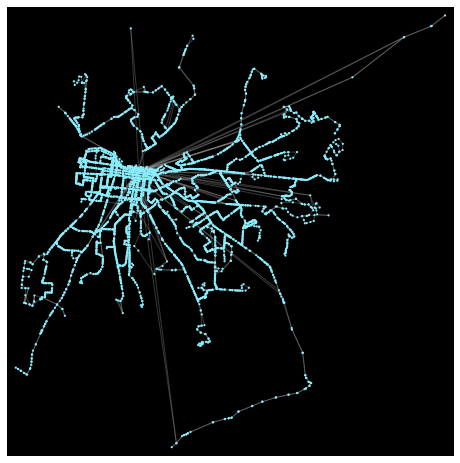

In [ ]:
ox.plot_graph(G,
                            figsize=(8,12),
                            show=False,
                            close=False,
                            node_color='#8aedfc',
                            node_size=5,
                            edge_color='#e2dede',
                            edge_alpha=0.25,
                            bgcolor='black')

# Team Code

In [ ]:
#checking if they have the same number of nodes and edges
#might loose information from converting MultiDiGraph -> DiGraph

Di_G = nx.DiGraph(G)

print("G #edges: " + str(G.number_of_edges()))
print("G #nodes: " + str(G.number_of_nodes()))
print()
print("Di_G #edges: " + str(Di_G.number_of_edges()))
print("Di_G #nodes: " + str(Di_G.number_of_nodes()))

G #edges: 4807
G #nodes: 4391

Di_G #edges: 4807
Di_G #nodes: 4391


/Users/jdm/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jdm/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


(<Figure size 576x864 with 1 Axes>, <AxesSubplot:>)

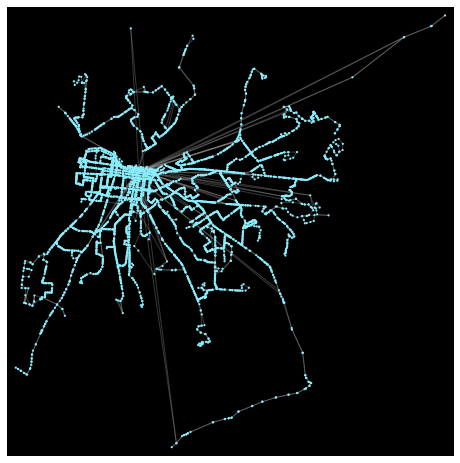

In [ ]:
#checking if the graphs are the same graph by
#converting DiGraph -> MultiDiGraph

backto_G = nx.MultiDiGraph(Di_G)

ox.plot_graph(backto_G,
                            figsize=(8,12),
                            show=False,
                            close=False,
                            node_color='#8aedfc',
                            node_size=5,
                            edge_color='#e2dede',
                            edge_alpha=0.25,
                            bgcolor='black')

In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric
!pip install torch==1.10.0+cu111 torchvision==0.11.0+cu111 torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch

# print torch version
print(torch.__version__)

In [ ]:
from torch_geometric.data import Data

In [ ]:
from collections import defaultdict, OrderedDict, Counter
import networkx as nx
import numpy as np
import peartree as pt
import random
import sys
from torch_geometric.data import Data

############### MY MODULES ###############
import sim
from sensor import *
from scenerio import *
from dsp_memo import DspMemo
import main_sim


for network in sim.network_file_list:
    print("starting simulation for " + network)
    reset_network()
    sim.network_file = network

    load_network()
    load_stop_times()
    format_stop_times()
    analyze_stops()
    get_departure_times_per_edge_per_route()
    add_departure_to_edge()
    generate_route_subgraphs()
    
    for seed in range(0, sim.no_of_seeds):
        reset_sim()

        sim.seed = seed
        np.random.seed(sim.seed)
        random.seed(sim.seed)

        randomly_select_sensor_locations()
        #assign_sensors_to_nodes()
        #generate_sensors()
        if network == 'louisville.zip':
            for algo in ["celf"]:
                for index in range(len(sim.louisville_gateways["celf"])):
                    generate_sensors()
                    load_gateways(sim.louisville_gateways[algo][:index + 1])
                    print_stats()
                    generate_route_subgraphs()
                    run_simulation()
                    t = store_results(algo + "_budget" + str(index + 1))
        elif network == 'cht.zip':
            for algo in ["celf"]:
                for index in range(len(sim.cht_gateways["celf"])):
                    generate_sensors()
                    load_gateways(sim.cht_gateways[algo][:index + 1])
                    print_stats()
                    generate_route_subgraphs()
                    run_simulation()
                    t = store_results(algo + "_budget" + str(index + 1))
        else:
            print("I don't know the city's gateways from sim.py, pele. I must quit!!!")
            sys.exit()


    # total = 0
    # n = 0
    # for v in t['ons']:
    #     total += v['delivery_rate']
    #     n += 1

    # total/n
    
import torch.nn.functional as F
from torch_geometric.nn import GeneralConv
import pandas as pd

class GeneralConv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        """ GeneralConv layers """
        self.conv1 = GeneralConv(data.num_features, 16)
        self.conv2 = GeneralConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

for network in sim.network_file_list:
    sim.network_file = network    
    feed = pt.get_representative_feed('data/gtfs/' + sim.network_file)
    df = feed.get('data/gtfs/' + sim.network_file)
    dictionary = df.to_dict()
    pyG_data = from_dict(dictionary)